<a href="https://colab.research.google.com/github/jbmmbj/m494/blob/main/INN_MNIST_5_28_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Invertible Neural Network Trained on MNIST Data**

## Install & Import Dependencies

In [ ]:
pip install FrEIA

In [ ]:
pip install torchvision

In [ ]:
pip install tensorflow

In [ ]:
pip install keras

In [ ]:
%matplotlib inline
from time import time

import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom, InvertibleSigmoid, AllInOneBlock


device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare MNIST Data

Load MNIST data

In [ ]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

2024-05-28 11:22:31.668764: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 11:22:33.320643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Flatten images

In [ ]:
x_train_t = torch.tensor(x_train)
x_train_flat = torch.flatten(x_train_t, 1, 2)
x_train_flat = x_train_flat / 255
x_test_t = torch.tensor(x_test)
x_test_flat = torch.flatten(x_test_t, 1, 2)
x_test_flat = x_test_flat / 255

One-hot encode labels

In [ ]:
y_train_t = torch.tensor(y_train)
y_test_t = torch.tensor(y_test)

zero = torch.tensor([1,0,0,0,0,0,0,0,0,0])
one = torch.tensor([0,1,0,0,0,0,0,0,0,0])
two = torch.tensor([0,0,1,0,0,0,0,0,0,0])
three = torch.tensor([0,0,0,1,0,0,0,0,0,0])
four = torch.tensor([0,0,0,0,1,0,0,0,0,0])
five = torch.tensor([0,0,0,0,0,1,0,0,0,0])
six = torch.tensor([0,0,0,0,0,0,1,0,0,0])
seven = torch.tensor([0,0,0,0,0,0,0,1,0,0])
eight = torch.tensor([0,0,0,0,0,0,0,0,1,0])
nine = torch.tensor([0,0,0,0,0,0,0,0,0,1])

In [ ]:
y_train_empty = torch.empty(60000, 10)

for i in range(len(y_train_t)):
  if y_train_t[i] == 0:
    y_train_empty[i] = zero
  elif y_train_t[i] == 1:
    y_train_empty[i] = one
  elif y_train_t[i] == 2:
    y_train_empty[i] = two
  elif y_train_t[i] == 3:
    y_train_empty[i] = three
  elif y_train_t[i] == 4:
    y_train_empty[i] = four
  elif y_train_t[i] == 5:
    y_train_empty[i] = five
  elif y_train_t[i] == 6:
    y_train_empty[i] = six
  elif y_train_t[i] == 7:
    y_train_empty[i] = seven
  elif y_train_t[i] == 8:
    y_train_empty[i] = eight
  elif y_train_t[i] == 9:
    y_train_empty[i] = nine

y_train_1hot = y_train_empty

In [ ]:
y_test_empty = torch.empty(10000, 10)

for i in range(len(y_test_t)):
  if y_test_t[i] == 0:
    y_test_empty[i] = zero
  elif y_test_t[i] == 1:
    y_test_empty[i] = one
  elif y_test_t[i] == 2:
    y_test_empty[i] = two
  elif y_test_t[i] == 3:
    y_test_empty[i] = three
  elif y_test_t[i] == 4:
    y_test_empty[i] = four
  elif y_test_t[i] == 5:
    y_test_empty[i] = five
  elif y_test_t[i] == 6:
    y_test_empty[i] = six
  elif y_test_t[i] == 7:
    y_test_empty[i] = seven
  elif y_test_t[i] == 8:
    y_test_empty[i] = eight
  elif y_test_t[i] == 9:
    y_test_empty[i] = nine

y_test_1hot = y_test_empty

## Build Network

In [ ]:
ndim_tot = 800
ndim_x = 784
ndim_y = 10
ndim_z = 784

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                         nn.Linear(512,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(8):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':2.0},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False)

## Training

Parameters and Loss Functions

In [ ]:
# Training parameters
n_epochs = 50
n_its_per_epoch = 50
batch_size = 1200

lr = 1e-3
l2_reg = 2e-5

y_noise_scale = 1e-1
zeros_noise_scale = 5e-2

# Each loss is weighted to make them comparable magnitudes:
lambd_predict = 3.
lambd_latent = 300.
lambd_rev = 400.

pad_x = torch.zeros(batch_size, ndim_tot - ndim_x)
pad_yz = torch.zeros(batch_size, ndim_tot - ndim_y - ndim_z)

trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=lr, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)


def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)


def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test_flat, y_test_1hot),
    batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_flat, y_train_1hot),
    batch_size=batch_size, shuffle=True, drop_last=True)

Define training loop

In [ ]:
def train(i_epoch=0):
    model.train()

    l_tot = 0
    batch_idx = 0

    t_start = time()

    loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch*10) / n_epochs)))

    for x, y in train_loader:
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break

        x, y = x.to(device), y.to(device)

        y_clean = y.clone()
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)

        y += y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)

        x, y = (torch.cat((x, pad_x),  dim=1),
                torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz, y),
                          dim=1))


        optimizer.zero_grad()

        # Forward step:

        output, _ = model(x)

        # Remove zero-padding for latent loss
        y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

        l = lambd_predict * loss_fit(output[:, ndim_z:], y[:, ndim_z:])

        output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)

        l += lambd_latent * loss_latent(output_block_grad, y_short)
        l_tot += l.data.item()

        l.backward()

        # Backward step:
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)

        orig_z_perturbed = (output.data[:, :ndim_z] + y_noise_scale *
                            torch.randn(batch_size, ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz,
                           y), dim=1)
        y_rev_rand = torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz,
                                y), dim=1)

        output_rev, _ = model(y_rev, rev=True)
        output_rev_rand, _ = model(y_rev_rand, rev=True)

        l_rev = (
            lambd_rev
            * loss_factor
            * loss_backward(output_rev_rand[:, :ndim_x],
                            x[:, :ndim_x])
        )

        l_rev += lambd_predict * loss_fit(output_rev, x)

        l_tot += l_rev.data.item()

        l_rev.backward()

        for p in model.parameters():
            if p.grad is not None:
              p.grad.data.clamp_(-15.00, 15.00)

        optimizer.step()

    return l_tot / batch_idx

Training

In [ ]:
for param in trainable_parameters:
    param.data = 0.05*torch.randn_like(param)

model.to(device)

N_samp = 200

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
y_samps += y_noise_scale * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z),
                     y_samps], dim=1)
y_samps = y_samps.to(device)

try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)

    # Sample the trained model
    rev_x, _ = model(y_samps, rev=True)
    rev_x = rev_x.cpu().data.numpy()

    pred_num, _ = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                              dim=1).to(device))
    pred_num = pred_num.data[:, -10:].argmax(dim=1)



except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining time: {(time()-t_start)/60:.2f} minutes\n")

100%|###########################################| 50/50 [04:15<00:00,  5.12s/it]



Training time: 4.26 minutes



## Testing normalizing direction (image classification)

Unflatten and plot first 20 input images

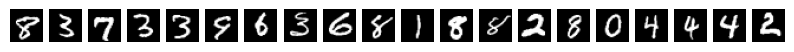

In [ ]:
x_samps_unflat = torch.unflatten(x_samps, 1, (28,28))

f, axarr = plt.subplots(1, 20, figsize=(10,10))

for i in range(20):
  axarr[i].imshow(x_samps_unflat[i].numpy(), cmap=plt.get_cmap('gray'))
  axarr[i].axis('off')

Print output labels of first 20 images

In [ ]:
print(f'{pred_num.cpu().data.numpy()[:20]}')

[8 3 7 3 3 9 6 3 6 8 1 8 8 2 8 0 4 4 4 2]


## Testing generative direction (image generation from label)

Normalize pixel values to 0-255 (greyscale)

In [ ]:
def normalize(values, actual_bounds, desired_bounds):
    return [desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0]) / (actual_bounds[1] - actual_bounds[0]) for x in values]

Plot first 20 output images

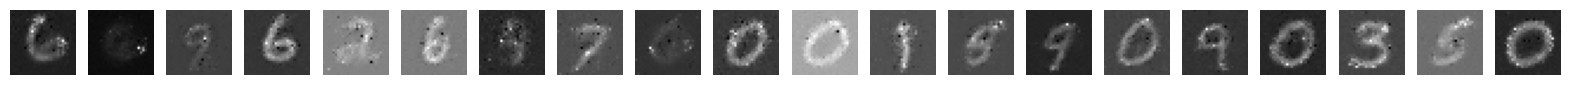

In [ ]:
f, axarr = plt.subplots(1, 20, figsize=(20,20))

for p in range(20):

  norm_x = normalize(
      (255*rev_x[p]),
      (min(rev_x[p]),max(rev_x[p])),
      (0,255)
  )

  x_trunc = np.trunc(norm_x)
  x_flat = x_trunc[0:784]
  x_im = np.reshape(x_flat, (28,28))

  axarr[p].imshow(x_im, cmap=plt.get_cmap('gray'))
  axarr[p].axis('off')

Print input labels of first 20 images

In [ ]:
for p in range (20):
  print(f'{torch.argmax(y_samps[p, -10:]).item()}', end=' ')

6 6 9 6 2 6 5 7 6 0 0 1 5 9 0 9 0 3 5 0 